In [1]:
# The following libraries need to be installed and avaible for the code below to work.
# !pip install xlwings   # visualizing the results in an excel sheet
# !pip install torch     # Computing the similarity Matrix
# !pip install Biopython # reading in sequences

In [16]:
# Import soft alignment functions
import torch
import xlwings as xw
from Bio import SeqIO
from soft_align import get_data_matrix, get_matches, get_longest_path

### Code needed to visualize the protein sequences alignments using the embeddings-based algorithm.

The notebook demonstrates how to execute a soft-alignment and visualize the outcome in Excel through the xlwings library. It produces a matrix resembling the one shown below.
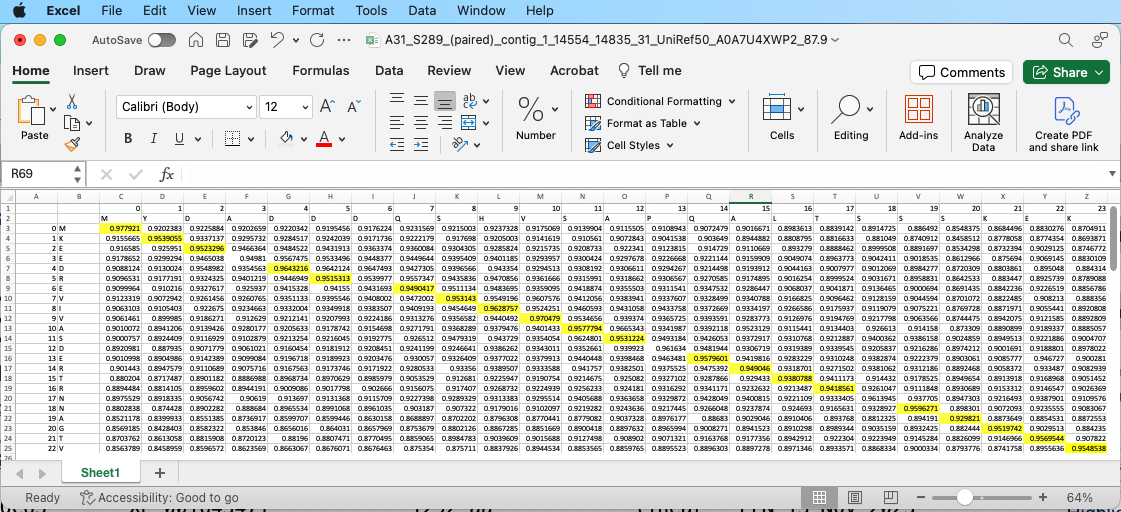


In [24]:

def build_excel_sheet(seq_1_str,seq_2_str,seq_1_embedding, seq_2_embedding):
    # Excel (the program should already be open)
    # Create new excel workbook containing an empty sheet
    wb = xw.Book()
    sheet = wb.sheets[0]
    
    ### Add first seq with indices at cols 0 and 1
    sheet['A3'].value = [[x] for x in range(0,len(seq_1_str))]
    sheet['B3'].value = [[x] for x in seq_1_str]

    # Add second seq with indices at rows 0 and 1
    sheet['C1'].value = list(range(0, len(seq_2_str)))
    sheet['C2'].value = list(seq_2_str)
    
    # Generate matrix containing cosine similarities of amino acid embeddings from sequence representations
    data = get_data_matrix(seq_1_embedding, seq_2_embedding)
    
    # Generate pairwise mutual matches of amino acids from the similarity matrix
    matches = get_matches(seq_1_str, seq_2_str, data)
    
    # Generate a longest path that diagonally traverses the matrix, to be considered a soft alignment.
    longest_path = get_longest_path(data, matches)
    
    ### Populate empty excel sheet with cosine distance matrix
    sheet['C3'].options(index=False).value = data.to_numpy()
    
    # Color longest path in cosine distance matrix 'yellow'
    for m in longest_path:
        m = (m[0]+2, m[1]+2)
        sheet[m].color = (254, 254, 69)

    return longest_path
    

In [3]:
# Set path for directories where sequence embeddings are stored and where sequences in fasta file is stored

embedding_directory = './soft_align_example_data/example_embeddings/'

fasta_directory = './soft_align_example_data/'
fasta_file = 'example.fasta'


In [10]:
# Load fasta file as a dictionary
# Keys in seqs dictionary are sequence names
# Values in seqs dictionary are the information for each sequence stored in the fasta file

seqs = SeqIO.to_dict(SeqIO.parse(fasta_directory + fasta_file, 'fasta'))

# Create a list of sequence names
seq_names = list(seqs.keys())
print("The sequences available in the data folder are:")
print(", ".join(seq_names))

The sequences available in the data folder are:
YP_006990334.1, YP_001468397.1, WP_016056174.1


In [7]:
seqs['YP_006990334.1'].seq[0:40]

Seq('MQNNKNFQNVLLAHINNIKDLPLKARIDYFEDDKDDLVIN')

In [12]:
# Create a string of the sequences to be compared

seq_1_str =  str(seqs[seq_names[0]].seq)
seq_2_str =  str(seqs[seq_names[1]].seq)


In [13]:
# Print the length of the sequence strings

print("Length Sequence 1: ", len(seq_1_str))
print("Length Sequence 2: ", len(seq_2_str))

Length Sequence 1:  135
Length Sequence 2:  135


In [18]:
# Load the sequences pytorch embeddings. Assumes the sequences were pre-computed

seq_1_embedding = torch.load(f"{embedding_directory + seq_names[0]}.pt")
seq_2_embedding = torch.load(f"{embedding_directory + seq_names[1]}.pt")

In [20]:
# Embeddings created by ESM2 are saved in a dictionary with the following structure. 
# When utilizing different formats, it's important to correctly use the "representations" field 
# that corresponds to the model being used.

print("Sequence 1 Dictionary Keys: ", seq_1_embedding.keys())
print("Sequence 2 Dictionary Keys: ", seq_2_embedding.keys())

Sequence 1 Dictionary Keys:  dict_keys(['label', 'representations'])
Sequence 2 Dictionary Keys:  dict_keys(['label', 'representations'])


In [21]:
# Generate matrix containing cosine similarities of amino acid embeddings from sequence representations

data = get_data_matrix(seq_1_embedding,seq_2_embedding)
data.iloc[0:5, 0:5]

,0,1,2,3,4
0,0.947351,0.838340,0.865979,0.830881,0.826368
1,0.866956,0.878017,0.888858,0.862527,0.836949
2,0.886032,0.876636,0.897953,0.880396,0.876158
3,0.852143,0.892888,0.901820,0.852618,0.876243
4,0.843087,0.852053,0.927681,0.866988,0.867131


In [22]:
# Shape of cosine distance matrix
# Shape corresponds to (length of sequence 1, length of sequence 2)

data.shape

(135, 135)

In [25]:
# Populate the excel sheet containing cosine distance matrix and colored longest path
# also return the longest path, i.e., propose alignment between the two sequences

longest_path = build_excel_sheet(seq_1_str,seq_2_str,seq_1_embedding, seq_2_embedding)

In [27]:
len(longest_path)

129